In [1]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-2_h46ggk
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-2_h46ggk
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-dwdt0qg8/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

/usr/local/lib/python3.12/dist-packages/torch_xla/experimental/gru.py:113: SyntaxWarning: invalid escape sequence '\_'
  * **h_n**: tensor of shape :math:`(D * \text{num\_layers}, H_{out})` or


In [3]:
# Load the AirPassengers dataset
df = pd.read_csv("/content/drive/MyDrive/Datasets/1990-2024.csv")
#df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    420 non-null    object 
 1   Price   420 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.7+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.tail(12)

,Date,Price
408,2024-01-01,9.17
409,2024-02-01,8.94
410,2024-03-01,8.91
411,2024-04-01,8.46
412,2024-05-01,8.16
413,2024-06-01,7.97
414,2024-07-01,7.79
415,2024-08-01,7.40
416,2024-09-01,6.81
417,2024-10-01,6.54


In [7]:
import plotly.express as px

fig = px.box(df, y="Price")
fig.update_layout(title='Box Plot of Price with Outliers')
fig.show()

# Alternatively, you can use a scatter plot to visualize outliers over time
# fig = px.scatter(df, x="Date", y="Price", title='Price over Time with Outliers')
# fig.show()

In [8]:
df_train = df[:-12]
df_test = df[-12:]

##--------

In [9]:
# Create a ChronosPipeline using the pre-trained 'chronos-t5-tiny' model
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda" if torch.cuda.is_available() else "cpu",  # Use GPU if available
    torch_dtype=torch.bfloat16,  # For memory efficiency
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [10]:
# Prepare the context (historical data)

context = torch.tensor(df_train["Price"])
#context = torch.tensor(df["Price"])

In [11]:
# Set the prediction length (number of time steps to forecast)
prediction_length = 12

In [12]:
# Generate the forecast
forecast = pipeline.predict(context, prediction_length)

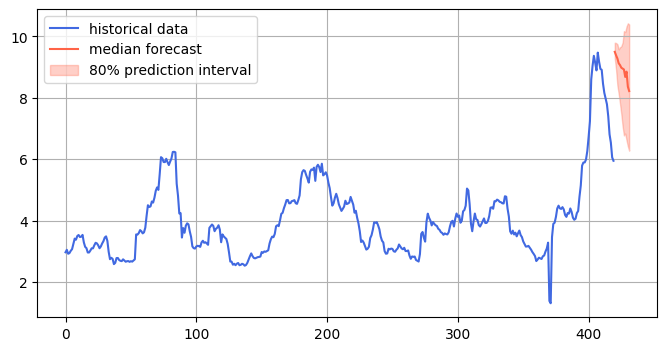

In [13]:
# Visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
plt.figure(figsize=(8, 4))
#plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(df["Price"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [15]:
forecast_index

range(408, 420)

In [16]:
median[-12:]


array([9.49450684, 9.3797698 , 9.27937508, 9.12161016, 9.06424189,
       8.97818899, 8.94950485, 8.92082024, 8.67700434, 8.84910965,
       8.36147642, 8.21805477])

In [17]:
low[-12:]

array([9.28224354, 8.91508341, 8.40163536, 8.12913361, 7.81073775,
       7.47226257, 7.07068267, 6.77523413, 6.83547111, 6.61747055,
       6.42241721, 6.27899575])

In [18]:
high[-12:]

array([ 9.79282379,  9.78135014,  9.74119148,  9.57482347,  9.64366493,
        9.67521763,  9.79856043, 10.17145605, 10.13703518, 10.32061501,
       10.42387877, 10.38658886])

In [19]:
df_train.tail(12)

,Date,Price
396,2023-01-01,5.893297
397,2023-02-01,5.895821
398,2023-03-01,5.989731
399,2023-04-01,6.269632
400,2023-05-01,6.727532
401,2023-06-01,7.235790
402,2023-07-01,8.599038
403,2023-08-01,9.034555
404,2023-09-01,9.364941
405,2023-10-01,9.145116


In [20]:
Prediction = pd.DataFrame({
    'Date': pd.date_range(start='2025-01-01', periods=prediction_length, freq='MS'),
    'Low': low[-prediction_length:].round(2),
    'Regular': median[-prediction_length:].round(2),
    'High': high[-prediction_length:].round(2)
})

display(Prediction)

,Date,Low,Regular,High
0,2025-01-01,9.28,9.49,9.79
1,2025-02-01,8.92,9.38,9.78
2,2025-03-01,8.40,9.28,9.74
3,2025-04-01,8.13,9.12,9.57
4,2025-05-01,7.81,9.06,9.64
5,2025-06-01,7.47,8.98,9.68
6,2025-07-01,7.07,8.95,9.80
7,2025-08-01,6.78,8.92,10.17
8,2025-09-01,6.84,8.68,10.14
9,2025-10-01,6.62,8.85,10.32


In [21]:
import plotly.graph_objects as go

fig = go.Figure([
    go.Scatter(
        name='Predictions',
        x=Prediction['Date'],
        y=Prediction['Regular'],
        mode='lines+text',
        text=Prediction['Regular'],
        textposition="top center",
        line=dict(color='tomato'),
        legendgroup='Forecast',
        showlegend=False
    ),
])

fig.update_layout(
    title='Oil Price Predictions - Year:2025',
    xaxis_title='Month)',
    yaxis_title='Price',
    hovermode='x unified',
    xaxis = dict(
        tickmode = 'array',
        tickvals = Prediction['Date'],
        tickformat = '%m',
        tickangle = 0  # Ensure angle is 0 as per previous request
    ),
    #showlegend=True,
    #legend=dict(
        #yanchor="top",
        #y=0.99,
        #xanchor="left",
        #x=0.01
    #)
)

fig.show()

In [22]:
median

array([9.49450684, 9.3797698 , 9.27937508, 9.12161016, 9.06424189,
       8.97818899, 8.94950485, 8.92082024, 8.67700434, 8.84910965,
       8.36147642, 8.21805477])

In [23]:
# Calculate Mean Absolute Error (MAE)
actual = df_test['Price'].values
#predicted = Prediction['Regular'].values
predicted = median[-12:].round(2)

mae = np.mean(np.abs(actual - predicted))
print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 1.26
